In [71]:
%reload_ext autoreload
%autoreload 2

In [72]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import torch.optim as optim
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display,clear_output

import warnings
warnings.filterwarnings("ignore")

In [73]:
from dataset import HelocDataset
from experiments import Benchmarking
from utils.logger_config import setup_logger
from tqdm import tqdm
from models.wrapper import PYTORCH_MODELS

logger = setup_logger()

In [74]:
from dataset import dataset_loader

In [75]:
name = 'heloc'
dataset_ares = dataset_loader(name, data_path='data/', dropped_features=[], n_bins=None)

In [76]:
from experiments.counterfactual import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from models import PyTorchDNN, PyTorchLinearSVM, PyTorchRBFNet, PyTorchLogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.gaussian_process import GaussianProcessClassifier

In [77]:
dataset = HelocDataset(dataset_ares=dataset_ares)

input_dim = dataset.get_dataframe().shape[1] - 1
seed = None
# torch.manual_seed(seed)

counterfactual_algorithms = [
    # 'DiCE',
    # 'DisCount',
    # 'GlobeCE',
    # 'AReS',
    'KNN',
]

experiment = Benchmarking(
    dataset=dataset,
    models=[
        # (GaussianProcessClassifier(),'sklearn'),
        # (PyTorchLogisticRegression(input_dim=input_dim), 'PYT'),
        (PyTorchDNN(input_dim=input_dim), 'PYT'),
        # (PyTorchRBFNet(input_dim=input_dim, hidden_dim=input_dim), 'PYT'),
        # (PyTorchLinearSVM(input_dim=input_dim), 'PYT'),
        # (RandomForestClassifier(n_estimators=10), 'sklearn'), 
        # (GradientBoostingClassifier(n_estimators=10), 'sklearn'), 
        # (AdaBoostClassifier(n_estimators=10), 'sklearn'), 
    ],
    shapley_methods=[
        # "Train_Distri",
        "CF_UniformMatch",
        # "CF_ExactMatch",
        "CF_SingleMatch",
        # "CF_OTMatch",
        "CF_OTMatch_2.0", 
        # "CF_OTMatch_50.0",
        # "CF_OTMatch_100.0",
        # "CF_OTMatch_10.0",
    ],
    distance_metrics=[
        'optimal_transport',
        'mean_difference',
        'median_difference',
        # 'max_mean_discrepancy',
    ]
)

experiment.train_and_evaluate_models(random_state=seed)
experiment.models_performance()

logger.info("\n\n------Compute Counterfactuals------")
sample_num = 300
model_counterfactuals = {}
for model, model_name in zip(experiment.models, experiment.model_names):
    model_counterfactuals[model_name] = {}

    for algorithm in counterfactual_algorithms:
        if algorithm == 'DisCount' and model_name not in PYTORCH_MODELS:
            logger.info(f'Skipping {algorithm} for {model_name} due to incompatability')
            continue
        logger.info(f'Computing {model_name} counterfactuals with {algorithm}')
        function_name = f"compute_{algorithm}_counterfactuals"
        try:
            func = globals()[function_name]
            model_counterfactuals[model_name][algorithm] = func(
                experiment.X_test,
                model = model,
                target_name = experiment.dataset.target_name,
                sample_num = sample_num,
                experiment=experiment,
            )
        except KeyError:
            print(f"Function {function_name} is not defined.")

INFO:root:PyTorchDNN accuracy: 0.7078481012658228
INFO:root:

------Compute Counterfactuals------
INFO:root:Computing PyTorchDNN counterfactuals with KNN


In [78]:
logger.info("\n\n------Compute Shapley Values------")
experiment.compute_shapley_values(
    model_counterfactuals=model_counterfactuals,
);

INFO:root:

------Compute Shapley Values------
INFO:root:Shapley values for PyTorchDNN using CF_UniformMatch with counterfactual by KNN


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.20701126, 0.14490788, 0.11440096, 0.09660526, 0.08523993,
       0.07762922, 0.07245394, 0.06900375, 0.06688056, 0.06586722])
INFO:shap:num_paired_subset_sizes = 11
INFO:shap:weight_left = 0.7167414131850209
INFO:shap:np.sum(w_aug) = 23.000000000000004
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = array([ 0.04608134, -0.00225506, -0.03741163, -0.04258489, -0.03314019,
       -0.00121472, -0.00093819,  0.04022762, -0.00899916,  0.01603754,
        0.00882592, -0.00873409, -0.02811988,  0.02623369, -0.03723304,
       -0.07743649,  0.05298471,  0.07726053, -0.02839729,  0.02931139,
        0.        ,  0.08655216, -0.02637777])
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.20701126, 0.14490788, 0.11440096, 0.09660526, 0.08523993,
       0.07762922, 0.07245394, 0.06900375, 0.06688056, 0.06586722])
INFO:shap:num_paired_subset_sizes = 11
INFO:shap:weight_left

In [88]:
logger.info("\n\n------Evaluating Distance Performance Under Interventions------")
experiment.evaluate_distance_performance_under_interventions(
    intervention_num_list=[0, 50, 100, 150, 200, 300, 400, 600, 800, 1200, 1600],
    trials_num=100,
    replace=False,
)

INFO:root:

------Evaluating Distance Performance Under Interventions------
INFO:root:Computing optimal_transport for (PyTorchDNN, KNN, CF_UniformMatch)
100%|██████████| 100/100 [00:55<00:00,  1.81it/s]
INFO:root:Computing mean_difference for (PyTorchDNN, KNN, CF_UniformMatch)
100%|██████████| 100/100 [00:05<00:00, 17.84it/s]
INFO:root:Computing median_difference for (PyTorchDNN, KNN, CF_UniformMatch)
100%|██████████| 100/100 [00:06<00:00, 16.09it/s]
INFO:root:Computing optimal_transport for (PyTorchDNN, KNN, CF_SingleMatch)
100%|██████████| 100/100 [00:47<00:00,  2.11it/s]
INFO:root:Computing mean_difference for (PyTorchDNN, KNN, CF_SingleMatch)
100%|██████████| 100/100 [00:02<00:00, 44.72it/s]
INFO:root:Computing median_difference for (PyTorchDNN, KNN, CF_SingleMatch)
100%|██████████| 100/100 [00:02<00:00, 43.66it/s]
INFO:root:Computing optimal_transport for (PyTorchDNN, KNN, CF_OTMatch_2.0)
100%|██████████| 100/100 [00:25<00:00,  3.87it/s]
INFO:root:Computing mean_difference for (Py

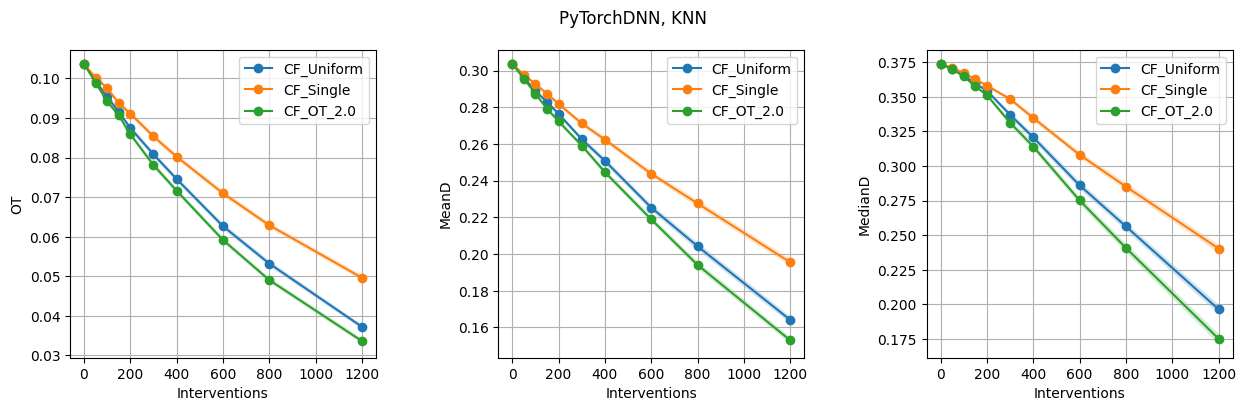

In [83]:
from experiments import plotting

plotting.intervention_vs_distance(experiment, save_to_file=False)

In [81]:
# X_factual = model_counterfactuals['PyTorchDNN']['KNN']['X_factual']
# X_counterfactual = model_counterfactuals['PyTorchDNN']['KNN']['X']

# X_baseline = X_counterfactual

# import ot
# N = X_factual.shape[0]
# reg = 0.1

# ot_cost = ot.dist(X_factual, X_counterfactual, p=2)
# # ot_plan = ot.bregman.sinkhorn(
# #     np.ones(N) / N, np.ones(N) / N, ot_cost, reg=reg, numItermax=5000
# # )
# ot_plan = ot.emd(np.ones(N) / N, np.ones(N) / N, ot_cost)

# weights = ot_plan[0]
# weights = weights + 1e-20
# weights = weights / (weights.sum())

# indice = np.random.choice(X_baseline.shape[0], p=weights, replace=True, size=1000)
# np.unique(indice), np.unique(indice).shape

In [87]:
model_counterfactuals['PyTorchDNN']['KNN']['X_factual'].shape

(300, 23)